<div style="float: right; width: 70%; height: 150px;">
  <div style="position: relative; top: 20%;padding-right:20%;">
  <div style="font-size:280%;font-weight: bold;padding-top: 20px;"> Exercise</div>
  <div style="font-size:180%;font-weight: bold;padding-top: 20px;color: rgba(0 , 0 , 0 , 0.5);"> Spectral response of buildings</div>
  </div>
</div>


We will calculate the spectral reponse of a building represented as a single-degree-of-freedom (SDOF) system due to shaking caused by an earthquake.

**Questions**:<br> 
**How does the building damping coefficient affect the spectral response?**<br> 
**At which frequencies the spectral response is strongest - what type of building would this be?**<br>


Note: this python script requires extra packages for
    - matplotlib (version 2.1.2) : > pip install -U matplotlib
    - numpy      (version 1.14.0): > pip install -U numpy
    - obspy      (version 1.1.0) : > pip install -U obspy

In [229]:
from __future__ import print_function
import os,sys

# for fixed plots
%matplotlib inline
# for interactive plots
#%matplotlib notebook
from IPython.display import display, clear_output

import matplotlib as mpl
print("matplotlib version: ",mpl.__version__)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 5
plt.rcParams['lines.linewidth'] = 0.5

## numpy
import numpy as np
print("numpy version: ",np.__version__)

# do not show scipy warnings
import warnings
warnings.filterwarnings('ignore')

matplotlib version:  3.5.1
numpy version:  1.21.0


uses obspy<br>
http://docs.obspy.org<br>
a python framework for seismology

In [230]:
import obspy
print("obspy version: ",obspy.__version__)

obspy version:  1.2.2


## Theory

To model the spectral response, we use a single-degree-of-freedom (SDOF) damped oscillator to mimick a building. The building has a specified mass $m$, stiffness $k$ and damping coefficient $c$. The spectral response is governed by the equation

$$
\partial_t^2 u(t) + 2 \xi \omega_0 \, \partial_t u(t) + \omega_0^2 \, u(t) = F(t)
$$

for the building's natural frequency $\omega_0 = \sqrt{\frac{k}{m}}$ and damping factor $\xi = \frac{c}{2 m \omega_0}$, driven by the earthquake ground motion $F(t)$. The building's natural period is $T_0 = \frac{2 \pi}{\omega_0}$. The earthquake forcing $F(t)$ is given by the ground motion acceleration recorded at the building site.<br>

To solve this equation, we discrectize $t^n = n \Delta t$ and solve the equation by a Newmark time scheme. The Newmark scheme is a predictor-corrector scheme using displacement $u(t)$, velocity $\dot{u}(t)$ and acceleration $\ddot{u}(t)$. 

Each time step starts with a predictor step for displacement, velocity and acceleration:
$$
{u}^{n+1} = {u}^{n} + \Delta t \, \dot{u}^{n} + \frac{\Delta t^2}{2} \, \ddot{u}^{n} \\
\dot{u}^{n+1} = \dot{u}^{n} + \frac{\Delta t}{2} \, \ddot{u}^{n} \\
\ddot{u}^{n+1} = 0
$$

followed by solving the right-hand side of the SDOF equation for acceleration $\ddot{u}$:
$$
\ddot{u}^{n+1} = - \omega_0^2 \, u^{n+1} - 2 \xi \omega_0 \, \dot{u}^{n+1} + F(t^{n+1})
$$

and finished by a corrector step for velocity:
$$
\dot{u}^{n+1} = \dot{u}^{n+1} + \frac{\Delta t}{2} \, \ddot{u}^{n+1}
$$

Since the equation holds a velocity damping term, the acceleration $\ddot{u}^{n+1}$ will have to be multiplied by a factor $\frac{1}{M + \frac{\Delta t}{2} C}$ where mass matrix $M = 1$ and damping matrix $C = 2 \xi \omega_0$ for our case.

## Earthquake

Let us get now a ground motion recording for one of the strongest earthquakes ever recorded in Taiwan:<br>

Chi-Chi earthquake, 1999, ~7.7 Mw

More than 2,400 people were killed, and many more injured, by the collapse and damage of buildings. About 50,000 buildings were completely destroyed and just as many were severly damaged. Building codes, the enforcement of those codes and the construction companies were heavily critized. One of the issues were so-called "soft stories", high open-ground floors in high-rise buildings with little structural support. This led to the ground floor collapsing first, either toppling the other floors or starting a cascading collapse of the whole building. Buildings over 50 m height required a stronger building review process and none of those reviewed buildings collapsed, highlighting the importance of monitoring such constructions (see [more](https://www.iccsafe.org/building-safety-journal/bsj-hits/today-in-history-the-chi-chi-earthquake-of-taiwan/)).

![Chi-Chi earthquake damage](https://www.iccsafe.org/wp-content/uploads/bsj/IMG_3786_Jiji_Earthquake.jpg)


In [231]:
print("getting event information...")
from obspy.clients.fdsn import Client

# Chi-Chi event local time: 21 Sep 1999 at 1:47am
#                           -> UTC time 20 Sep 1999, 17:47
event_time = obspy.UTCDateTime("1999-09-20T17:47:12.6")

# data client
# data centers: FDSN, IRIS, ORFEUS, IPGP, ETH, GFZ, RESIF, GEONET, USGS, ..
c = Client("IRIS")  

starttime = event_time - 10 * 60
endtime = event_time + 10 * 60
Mw_min = 7.0

catalog = c.get_events(starttime=starttime, endtime=endtime, minmagnitude=Mw_min)
# or
#catalog = c.get_events(eventid=3320897)
print("Event catalog:")
print(catalog)

getting event information...
Event catalog:
1 Event(s) in Catalog:
1999-09-20T17:47:16.340000Z | +23.850, +120.870 | 7.7 Mw


We will look at the shaking record of a station in Hualien City:<br>
Station: TW.HWAB

In [232]:
print("getting station information...")

# gets station informations
t1 = event_time
t2 = t1 + 5 * 60

net = "TW"    # Taiwan network
sta = "HWAB"  # station name
loc = "*"
cha = "BHZ"   # vertical component

# stations HWAB has some valuable records
inventory = c.get_stations(network=net, station=sta,starttime=t1,endtime=t2)
print(inventory)

# dowloads seismogram as a stream
st = c.get_waveforms(network=net, station=sta, location=loc, channel=cha,
                     starttime=t1,endtime=t2, attach_response=True)
print(st)
print("")

getting station information...
Inventory created at 2022-04-12T15:01:55.728000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?starttime=1999-09-20...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			TW
		Stations (1):
			TW.HWAB (Hualien)
		Channels (0):

1 Trace(s) in Stream:
TW.HWAB..BHZ | 1999-09-20T17:47:12.640506Z - 1999-09-20T17:52:12.590506Z | 20.0 Hz, 6000 samples



trace:
  dt       =  0.05
  duration =  300.0 s  =  5.0 min  =  0.08333333333333333 h
  Nyquist frequency =  10.0
  minimum frequency =  0.0033333333333333335



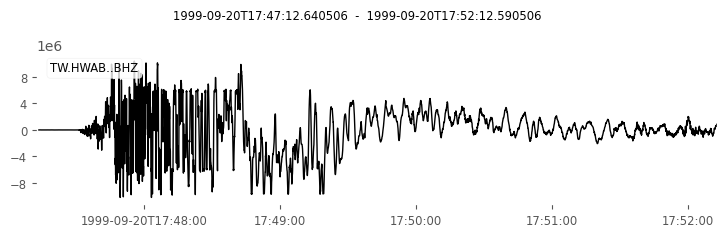

In [233]:
# trace statistics
tr = st[0]

#print(tr.stats)
npts = tr.stats.npts      # number of samples
dt = tr.stats.delta       # time step
duration = npts * dt

freq_Ny = 1.0/(2.0 * dt)  # Nyquist frequency
freq_min = 1./duration    # minimal possible frequency for length of trace

print("trace:")
print("  dt       = ",dt)
print("  duration = ",duration,"s"," = ",duration/60.,"min"," = ",duration/60./60.,"h")
print("  Nyquist frequency = ",freq_Ny)
print("  minimum frequency = ",freq_min)
print("")

# plotting traces
st.plot();

data converted to acceleration:
  vertical acceleration min/max =  -0.414050524527 / 0.366192560286 (m)


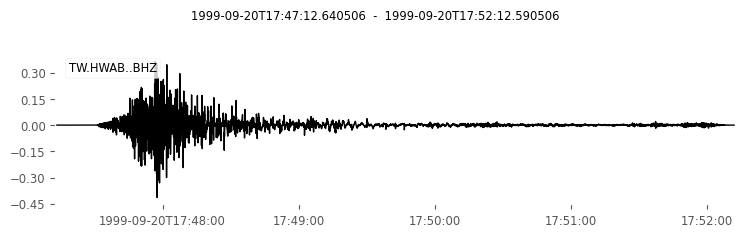

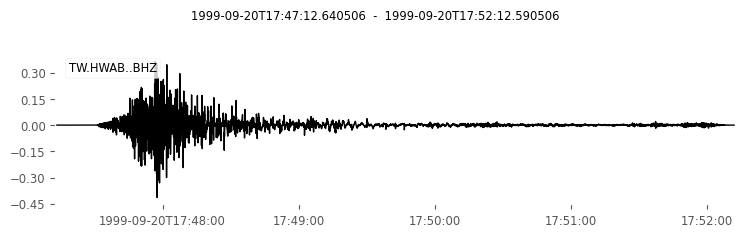

In [234]:
# detrending & tapering
st.detrend("linear")
st.detrend("demean")
st.taper(max_percentage=0.05)

# instrument response removal
# (unstable procedure)
#
# STS-2 instrument has a broadband range between 120s - 50 Hz
# frequency range
f1 = 1.0/150.0  # low-frequency taper range (Hz)
f2 = 1.0/120.0  
f3 = 50.0        # high-frequency taper range (Hz)
f4 = 60.0

st_accel = st.copy()
st_accel.remove_response(output="ACC",pre_filt=(f1,f2,f3,f4))

print("data converted to acceleration:")
print("  vertical acceleration min/max = ",st_accel[0].data.min(),"/",st_accel[0].data.max(),"(m)")

# plotting
st_accel.plot()



## Model spectral response

Let us model the spectral response for this ground motion record.


In [235]:
# spectral response
def spectral_response(F,T_period,damping,deltat,show_info=False):
    
    # sets natural frequency
    omega_0 = 2.0 * np.pi / T_period

    # building damping coefficient
    c = damping
    
    # equation: a + 2 xi omega v + omega^2 d = F    
    #            
    # we model: M a + C v + K d = F
    #           and M = 1    
    #               C = 2 xi omega
    #               K = omega^2    
    #         
    # the building damping given as input here is directly xi, not c since we don't know mass and stiffness
    # of the building.
    #
    # therefore, factor xi = c / (2.0 * m * omega_0) becomes just xi = c_damping
    #
    # sets damping factor
    xi = c 

    print("spectral response - natural period              = {:1.2f} (s)".format(T_period))
    print("                    building damping            = {:.1f} (%)".format(c * 100.0))
    #print("                    natural (angular) frequency = {:1.2} (Hz)".format(omega_0))


    # as example: mass estimation & effective stiffness of the building
    #
    #       wave speeds defined c = sqrt( kappa /rho ) 
    #       with units c [m/s] and elastic modulus kappa in [N/m^2]=[Pascal] and density rho in [kg/m^3]
    #
    #       for buildings, we define stiffness k in [N/m] = [Pascal * m], and mass m in [kg]
    #       -> frequency omega = sqrt(k/m) has units sqrt([N/m]/[kg]) = sqrt([kg m s^(-2) / m] / [kg] ) 
    #                                                                 = sqrt([1/s^2]) = [1/s] = [Hz]
    #
    #       stiffness k would related to the elastic modulus kappa by a certain area A (e.g., base area),
    #       and length L of the structure (e.g., building height):
    #         k = kappa * A/L
    #
    if show_info:
        # assumed effective building stiffness
        k = 80.0 * 10**6  # 80,000 kN/m = 80.0 * 10**6 N/m    
        # estimated building mass: omega_0 = sqrt( k / m ) with k = [N/m], m = [kg] -> omega = [Hz]
        m = k / (omega_0**2)
        print("                    example: building stiffness  = {:.2f} (kN/m)".format(k/1000.0))
        print("                             building mass       = {:.2f} (tons)".format(m/1000.0))
            
    # time loop    
    DT = deltat    
    NSTEP = len(F)
    
    u = np.zeros(NSTEP)     # displacement
    v = np.zeros(NSTEP)     # velocity
    a = np.zeros(NSTEP)     # acceleration

    # Newmark scheme for equations with damping: 
    #  system: M a + C v + K d = F 
    #  -> requires a mass matrix correction (M + DT/2 C) to solve for a in a Newmark scheme:
    #       a = 1/(M + DT/2 C) [ - K d - C v  + F]
    #
    #  in our case: a + 2 xi omega * v + omega^2 * d = F 
    #  and therefore M = 1, C = 2 xi omega_0 
    #  -> the mass "correction" factor becomes: 1/(1 + DT/2 C)
    #
    # stability condition:
    #   the scheme we use is an explicit scheme and imposes a stability condition on the time step size:
    #   (see Hughes, 1987, book on Finite-element method, chapter 9, section 9.1.2)
    #     dt/T < C_critical / (2 pi) 
    #   or
    #     dt   < T/(2pi) * C_critical = 1/omega * C_critical
    #  with constant C_critical~2 and period T
    if DT >= 2.0 / omega_0:    
        print("  stability condition not satisfied: DT =",DT," should be < ",2.0/omega_0)        
        return u,v,a
        
    fac_damp_scheme = 1.0 / (1.0 + DT/2.0 * 2.0 * xi * omega_0)
    
    for i in range(len(F)-1):        
        # predictor
        u[i+1] = u[i] + DT * v[i] + DT**2/2.0 * a[i]
        v[i+1] = v[i] + DT/2.0 * a[i]
        a[i+1] = 0.0
        
        # solve
        a[i+1] = - omega_0**2 * u[i+1] - 2.0 * xi * omega_0 * v[i+1] + F[i+1] 
        a[i+1] = fac_damp_scheme * a[i+1]
        
        # corrector
        v[i+1] = v[i+1] + DT/2.0 * a[i+1]
    
        # checks stability of the scheme
        if u[i+1] > 1.e50: 
            print("modeling became unstable")
            u[:] = 0.0
            v[:] = 0.0
            a[:] = 0.0
            return u,v,a
            
    return u,v,a   # displacement,velocity,acceleration

spectral response - natural period              = 1.00 (s)
                    building damping            = 5.0 (%)
                    example: building stiffness  = 80000.00 (kN/m)
                             building mass       = 2026.42 (tons)

spectral response:
   displacement min /max = -0.008587228426733947 / 0.008098752890527312 (m)
   velocity     min /max = -0.056270516337537074 / 0.054649411297259455 (m/s)
   acceleration min /max = -0.6640745932000901 / 0.530448351415888 (m/s^2)


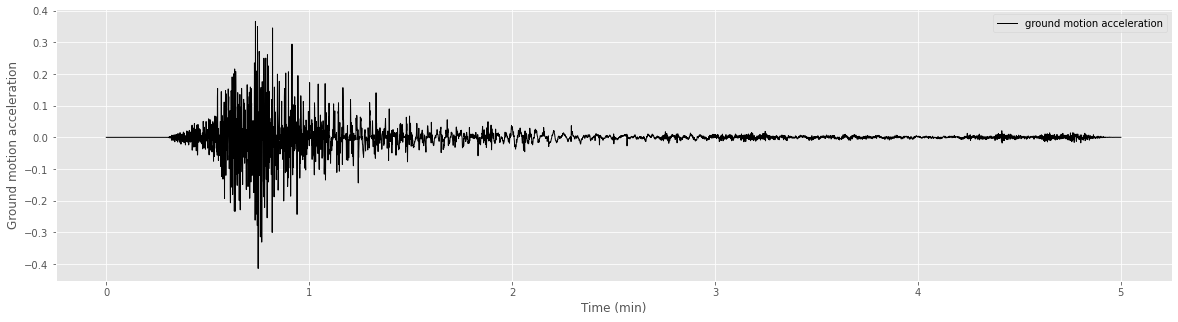

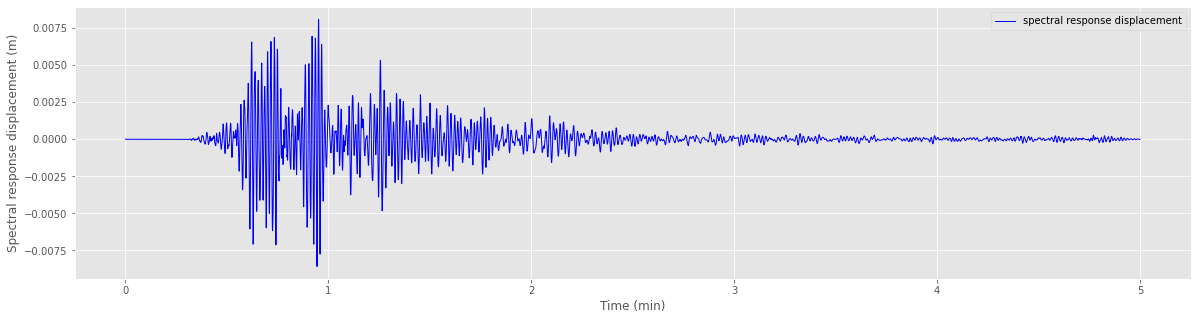

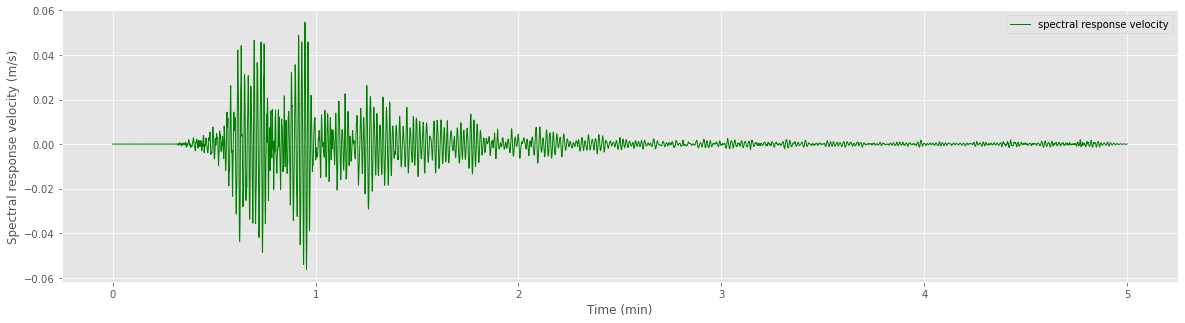

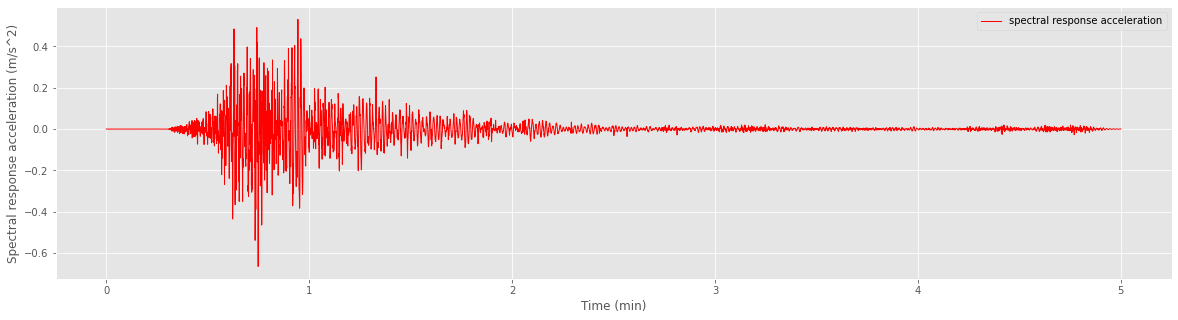

In [253]:
# selects trace
tr = st_accel[0]   

# ground motion acceleration data
F = tr.data.copy()

# time step
deltat = tr.stats.delta

## building
# assuming 5% damping for the building
damping  = 0.05
# natural period of 1s
T_period = 1.0

# spectral response
u,v,a = spectral_response(F,T_period,damping,deltat,show_info=True)

print("")
print("spectral response:")
print("   displacement min /max = {} / {} (m)".format(u.min(),u.max()))
print("   velocity     min /max = {} / {} (m/s)".format(v.min(),v.max()))
print("   acceleration min /max = {} / {} (m/s^2)".format(a.min(),a.max()))

# plotting
# time axis for plotting (in min)
npts = tr.stats.npts      # number of samples
dt = tr.stats.delta       # time step
duration = npts * dt
t_d = np.linspace(0,duration,npts) / (60.0)  

# ground motion acceleration
plt.plot(t_d, F, color='black', linewidth=1.0,label="ground motion acceleration")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Ground motion acceleration")
plt.show()


# spectral response displacement
plt.plot(t_d, u, color='blue', linewidth=1.0,label="spectral response displacement")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Spectral response displacement (m)")
plt.show()

# spectral response velocity
plt.plot(t_d, v, color='green', linewidth=1.0,label="spectral response velocity")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Spectral response velocity (m/s)")
plt.show()


# spectral response acceleration
plt.plot(t_d, a, color='red', linewidth=1.0,label="spectral response acceleration")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Spectral response acceleration (m/s^2)")
plt.show()



In [254]:
# computes spectral response over a given period range
# range of natural periods
Np = 40
DeltaTp = 0.2
# range starting at 0.1 s 
periods = np.linspace(0.1,Np*DeltaTp,Np)

# maximum spectral_response values at each period
spectral_max_u = np.zeros(Np)
spectral_max_v = np.zeros(Np)
spectral_max_a = np.zeros(Np)
spectral_max_a_total = np.zeros(Np)

for i,T_period in enumerate(periods):
    # spectral response
    u,v,a = spectral_response(F,T_period,damping,deltat)
    
    # determines absolute maximum
    spectral_max_u[i] = np.abs(u).max()
    spectral_max_v[i] = np.abs(v).max()
    spectral_max_a[i] = np.abs(a).max()
    
    print("  maximum: displ = {} / veloc = {} / accel = {}".format(spectral_max_u[i],spectral_max_v[i],spectral_max_a[i]))
    print("")

    ## spectral response acceleration   
    # take total acceleration
    a_total = a + F    
    # convert acceleration to unit of g (9.81 m/s^2 average gravitational acceleration)
    a_total /= 9.81
    
    spectral_max_a_total[i] = np.abs(a_total).max()
    

spectral response - natural period              = 0.10 (s)
                    building damping            = 5.0 (%)
  stability condition not satisfied: DT = 0.05  should be <  0.0318309886184
  maximum: displ = 0.0 / veloc = 0.0 / accel = 0.0

spectral response - natural period              = 0.30 (s)
                    building damping            = 5.0 (%)
  maximum: displ = 0.002398235932706784 / veloc = 0.044095743659230136 / accel = 1.154021401017515

spectral response - natural period              = 0.51 (s)
                    building damping            = 5.0 (%)
  maximum: displ = 0.00580375242450499 / veloc = 0.07239621485196177 / accel = 1.1277158186205467

spectral response - natural period              = 0.71 (s)
                    building damping            = 5.0 (%)
  maximum: displ = 0.006052588413105107 / veloc = 0.06363699080643634 / accel = 0.6261075721936149

spectral response - natural period              = 0.91 (s)
                    building damping         

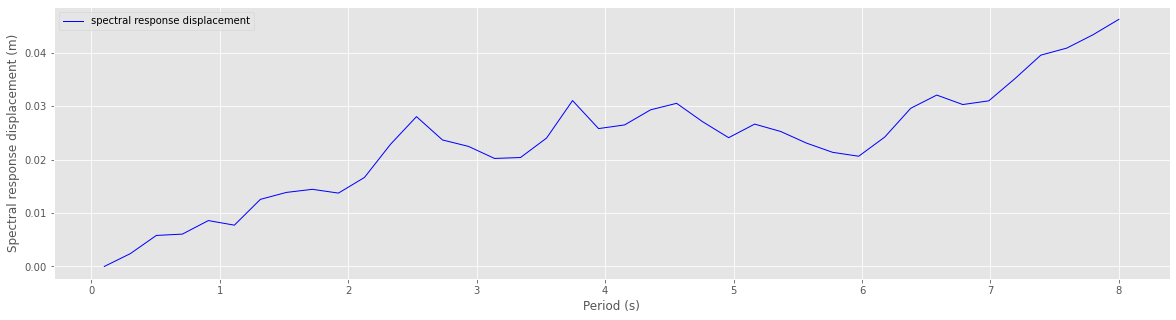

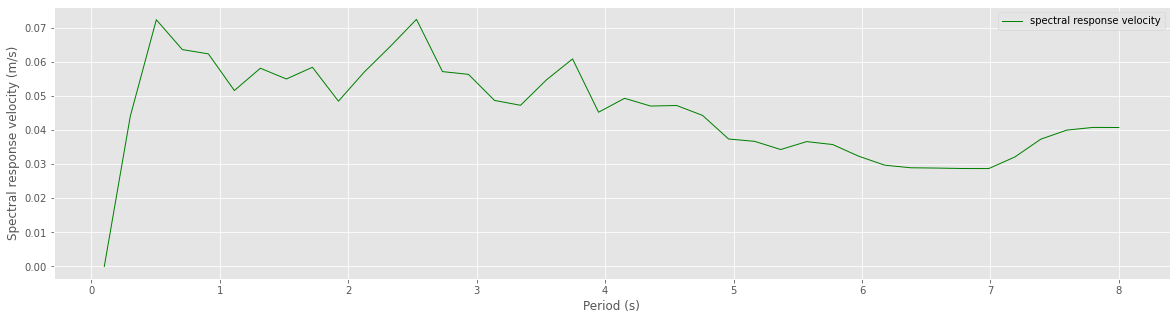

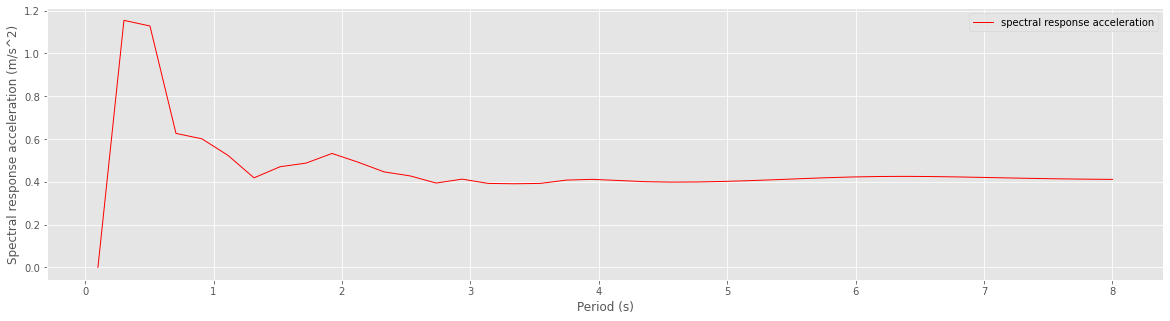

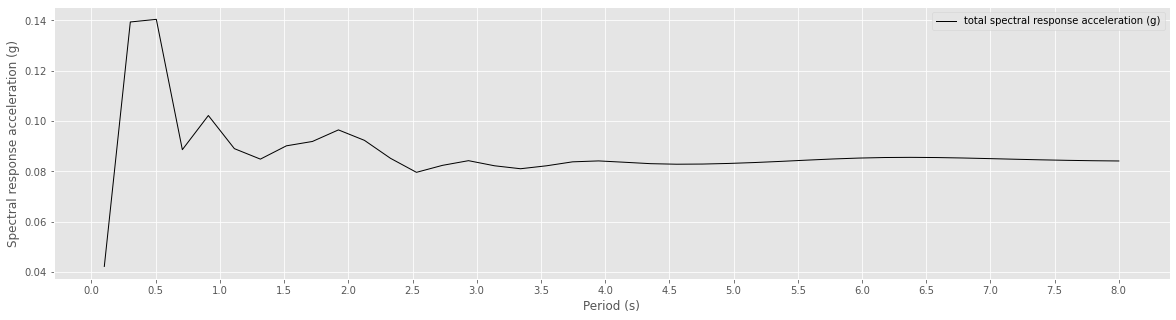

In [257]:
# plot    
# spectral response displacement
plt.plot(periods, spectral_max_u, color='blue', linewidth=1.0,label="spectral response displacement")
plt.legend()
plt.xlabel("Period (s)")
plt.ylabel("Spectral response displacement (m)")
plt.show()

# spectral response velocity
plt.plot(periods, spectral_max_v, color='green', linewidth=1.0,label="spectral response velocity")
plt.legend()
plt.xlabel("Period (s)")
plt.ylabel("Spectral response velocity (m/s)")
plt.show()

# spectral response displacement
plt.plot(periods, spectral_max_a, color='red', linewidth=1.0,label="spectral response acceleration")
plt.legend()
plt.xlabel("Period (s)")
plt.ylabel("Spectral response acceleration (m/s^2)")
plt.show()

# total spectral response acceleration
plt.plot(periods, spectral_max_a_total, color='black', linewidth=1.0,label="total spectral response acceleration (g)")
plt.legend()
plt.xlabel("Period (s)")
plt.ylabel("Spectral response acceleration (g)")
plt.xticks(np.arange(0.0, max(periods)+DeltaTp, 0.5))
plt.show()

Now, change the building damping factor and see what happens...